# Simulation experiment

**Hypothesis**: If we generate a gene expression dataset with a strong signal, a nonlinear compression method (VAE)
            will be able to learn this signal and predict new gene expression patterns better compared to 
            using a linear comparession method (PCA) and using no compression method (all the genes)
 
**Study design**:

*(Input)* Add signal to Pa gene expression dataset:

Network: gene set A --> gene set B

Add signal to relate A and B using the following algorithm:

Hyperparmeters should include:
 1. Size of gene set A
 2. Size of gene set B
 3. Effect size
 4. Log file with hyperparameter selections
         
*(Approach)* Train nonlinear (VAE) and linear (PCA) compression algorithms using this simulated data

*(Evaluation)*  For each sample in the Pa dataset compare corr(predicted expression, actual expression)

*(Output)* Figure of the correlation scores per sample 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import seaborn as sns

from functions import generate_input, vae, def_offset, interpolate, pca, plot

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Hyperparameters

# Size of the gene set A
geneSetA_size = 1000

# Size of the gene set that will be regulated by gene A
geneSetB_size = 1000 

# Set mean and standard deviation for distribution of A genes
mu_A, sigma_A = 0.5, 0.4 # mean and standard deviation

# Set mean and standard deviation for distribution of B genes if mean(A) is ABOVE threshold
mu_B, sigma_B = 0.8, 0.1 # mean and standard deviation

# Name of analysis
analysis_name = 'sim_distAB_1000AB'

In [3]:
# Create list of base directories
base_dirs = [os.path.join(os.path.dirname(os.getcwd()), 'data'),
             os.path.join(os.path.dirname(os.getcwd()), 'encoded'),
             os.path.join(os.path.dirname(os.getcwd()), 'models'),
             os.path.join(os.path.dirname(os.getcwd()), 'output'),
             os.path.join(os.path.dirname(os.getcwd()), 'stats'),
             os.path.join(os.path.dirname(os.getcwd()), 'viz')    
]

# Check if directory exist otherwise create
for each_dir in base_dirs:
    analysis_dir = os.path.join(each_dir, analysis_name)
    
    if os.path.exists(analysis_dir):
        print('directory already exists: {}'.format(analysis_dir))
    else:
        print('creating new directory: {}'.format(analysis_dir))
    os.makedirs(analysis_dir, exist_ok=True)

directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/data/sim_distAB_1000AB
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/encoded/sim_distAB_1000AB
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/models/sim_distAB_1000AB
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/output/sim_distAB_1000AB
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/stats/sim_distAB_1000AB
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/viz/sim_distAB_1000AB


In [4]:
# Load arguments
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")

In [5]:
# Read in data
data = pd.read_table(data_file, header=0, sep='\t', index_col=0, compression='zip').T
data.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.472897,0.396658,0.253776,0.000000,0.175640,0.554385,0.411370,0.382222,0.310144,0.642522,...,0.358597,0.390048,0.457406,0.684082,0.338351,0.608325,0.643496,0.276075,0.112773,0.145170
0.1_2hr_CSV86(Pae_G1a).CEL,0.262346,0.086216,0.359853,0.439214,0.269749,0.768433,0.212505,0.062043,0.567695,0.467073,...,0.358504,0.414206,0.389879,0.477693,0.000000,0.479385,0.154471,0.140891,0.167505,0.157060
0.1_6hr_CSV86(Pae_G1a).CEL,0.473658,0.244862,0.330750,0.097697,0.387226,0.328319,0.228820,0.330039,0.318081,0.512864,...,0.180744,0.380741,0.173501,0.251571,0.182793,0.528301,0.504985,0.499782,0.061106,0.365612
0.1_7hr_CSV86(Pae_G1a).CEL,0.439273,0.343402,0.192698,0.274677,0.628979,0.553796,0.431391,0.363480,0.385721,0.094584,...,0.346837,0.153927,0.067349,0.319723,0.282442,0.490655,0.531415,0.153880,0.132333,0.260087
0.1_9hr_CSV86(Pae_G1a).CEL,0.220827,0.145525,0.437803,0.293201,0.635120,0.462893,0.488733,0.309584,0.318646,0.591914,...,0.237726,0.301945,0.070222,0.513605,0.114277,0.360259,0.386868,0.223995,0.105343,0.102088


In [6]:
# Randomly select genes for set A
gene_ids = list(data.columns)
geneSetA = random.sample(gene_ids, geneSetA_size)

In [7]:
# checkpoint:  Check the number of genes
assert(len(gene_ids)==5549)
print("Confirmed that all gene ids are available")

Confirmed that all gene ids are available


In [8]:
# Remove gene ids that were selected for gene set A
gene_ids = [elem for elem in gene_ids if elem not in geneSetA]
print("After removing {} gene ids for set A, there are {} gene ids remaining."
      .format(geneSetA_size, len(gene_ids)))

After removing 1000 gene ids for set A, there are 4549 gene ids remaining.


In [9]:
# Randomly select genes for gene set B
geneSetB = random.sample(gene_ids, geneSetB_size)

# Remove gene ids that were selected for gene set B
gene_ids = [elem for elem in gene_ids if elem not in geneSetB]
print("After removing {} gene ids for set B, there are {} gene ids remaining."
      .format(geneSetB_size, len(gene_ids)))

After removing 1000 gene ids for set B, there are 3549 gene ids remaining.


In [10]:
# checkpoint:  Check that genes in set A are distinct from genes in set B
assert(len(set(geneSetA).intersection(set(geneSetB))) == 0)

## Output gene groupings 
Output gene assignments (group A, B) to be used in [explore_simulated_data.py](explore_simulated_data.ipynb)

In [11]:
# Output gene groupings
geneSetA_df = pd.DataFrame(geneSetA, columns=['gene id'])
geneSetB_df = pd.DataFrame(geneSetB, columns=['gene id'])

geneSetA_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetA.txt")
geneSetB_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetB.txt")


geneSetA_df.to_csv(geneSetA_file, sep='\t')
geneSetB_df.to_csv(geneSetB_file, sep='\t')

In [12]:
data[geneSetA]

Gene_symbol,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5556,PA0593,PA0204,PA3744,PA0822,PA2525,PA0014,PA1626,PA2274,PA3080
0.1_12hr_CSV86(Pae_G1a).CEL,0.403359,0.022822,0.572633,0.240777,0.018073,0.564859,0.213503,0.443926,0.200918,0.249462,...,0.241529,0.223540,0.480284,0.350451,0.567599,0.715886,0.570834,0.067297,0.395022,0.388721
0.1_2hr_CSV86(Pae_G1a).CEL,0.741909,0.413442,0.469715,0.000000,0.054008,0.522637,0.323271,0.153612,0.494937,0.214909,...,0.264910,0.539708,0.561181,0.331252,0.461184,0.586787,0.450031,0.673466,0.351044,0.218031
0.1_6hr_CSV86(Pae_G1a).CEL,0.345614,0.273798,0.538997,0.541692,0.063036,0.409330,0.256069,0.286615,0.000000,0.223898,...,0.227754,0.206908,0.586715,0.328507,0.511761,0.475914,0.817037,1.000000,0.392017,0.429850
0.1_7hr_CSV86(Pae_G1a).CEL,0.490771,0.483542,0.545365,0.057900,0.261723,0.644444,0.326587,0.224972,0.309617,0.358319,...,0.372871,0.423948,0.723811,0.107261,0.656752,0.562571,0.473934,0.504283,0.256474,0.431243
0.1_9hr_CSV86(Pae_G1a).CEL,0.564879,0.377730,0.383562,0.463751,0.198875,0.393370,0.526560,0.415069,0.306389,0.346598,...,0.315086,0.546499,0.797610,0.231937,0.363340,0.588223,0.392089,0.799798,0.487158,0.104842
05_PA14000-4-2_5-10-07_S2.CEL,0.525608,0.645718,0.769470,0.782706,0.912618,0.232935,0.601528,0.335385,0.379453,0.149852,...,0.976672,0.769610,0.247416,0.772538,0.272325,0.552839,0.330638,0.405359,0.205299,0.341307
1_12hr_CSV86(Pae_G1a).CEL,0.526852,0.170710,0.183756,0.430143,0.259886,0.438878,0.378888,0.337180,0.185451,0.173152,...,0.135794,0.381705,0.795866,0.236540,0.610079,0.731158,0.977924,0.560239,0.358294,0.000000
1_2hr_CSV86(Pae_G1a).CEL,0.386476,0.168975,1.000000,0.245997,0.035647,0.489212,0.586709,0.322626,0.514025,0.508316,...,0.337377,0.020267,0.631909,0.180936,0.821590,0.503271,0.698910,0.859315,0.170248,0.533967
1_6hr_CSV86(Pae_G1a).CEL,0.013166,0.228507,0.742457,0.005446,0.265718,0.363592,0.425608,0.300056,0.442055,0.313457,...,0.132787,0.158177,0.468007,0.095840,0.509251,0.918489,0.604090,0.402956,0.436289,0.232162
1_7hr_CSV86(Pae_G1a).CEL,0.809445,0.345771,0.575614,0.074847,0.283726,0.464666,0.204379,0.541102,0.207780,0.392315,...,0.144580,0.266459,0.511774,0.283282,0.649791,0.576525,0.564473,0.620979,0.453782,0.248336


In [13]:
data[geneSetB]

Gene_symbol,PA0308,PA2691,PA3664,PA0069,PA4467,PA4255,PA5157,PA4881,PA0128,PA5140,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
0.1_12hr_CSV86(Pae_G1a).CEL,0.462973,0.328041,0.154238,0.227769,0.479584,0.155805,0.411994,0.336567,0.628558,0.884362,...,0.039832,0.254098,0.307685,0.161177,0.374437,0.641319,0.359890,0.299781,0.479138,0.450044
0.1_2hr_CSV86(Pae_G1a).CEL,0.591943,0.177981,0.419127,0.310659,0.178558,0.369365,0.473495,0.125862,0.379667,0.485076,...,0.233275,0.412733,0.270773,0.155429,0.513619,0.182190,0.043469,0.647988,0.135370,0.194866
0.1_6hr_CSV86(Pae_G1a).CEL,0.364666,0.127274,0.293608,0.268601,0.366303,0.360815,0.522218,0.134549,0.199127,0.302114,...,0.030076,0.031428,0.521199,0.492192,0.527667,0.354451,0.307287,0.380950,0.345030,0.142117
0.1_7hr_CSV86(Pae_G1a).CEL,0.640302,0.205229,0.002028,0.211266,0.364542,0.468198,0.217490,0.166325,0.423315,0.173137,...,0.277471,0.260051,0.304556,0.311626,0.363941,0.316971,0.293693,0.424367,0.280251,0.143105
0.1_9hr_CSV86(Pae_G1a).CEL,0.000000,0.332581,0.542821,0.456474,0.275490,0.220378,0.383375,0.222402,0.546465,0.583920,...,0.022703,0.132679,0.244804,0.442813,0.417270,0.421753,0.214937,0.366768,0.439600,0.269447
05_PA14000-4-2_5-10-07_S2.CEL,0.681426,0.106117,0.772890,0.167727,0.115531,0.798038,0.457533,0.113521,0.506254,0.879994,...,0.621004,0.078774,0.131616,0.137196,0.452241,0.490611,0.647142,0.243247,0.758300,0.298682
1_12hr_CSV86(Pae_G1a).CEL,0.406954,0.266234,0.366849,0.249661,0.324541,0.513897,0.299346,0.332053,0.305713,0.233180,...,0.140419,0.265773,0.260137,0.469982,0.560268,0.213321,0.225104,0.388838,0.228681,0.280815
1_2hr_CSV86(Pae_G1a).CEL,0.539504,0.350029,0.229114,0.491158,0.632467,0.333757,0.524784,0.149288,0.417639,0.089884,...,0.140248,0.270286,0.299044,0.286246,0.525373,0.367953,0.397721,0.361805,0.499513,0.069543
1_6hr_CSV86(Pae_G1a).CEL,0.562767,0.448088,0.184063,0.401171,0.214937,0.229977,0.417510,0.210248,0.310343,0.546817,...,0.000000,0.181389,0.335187,0.249512,0.342715,0.316176,0.264503,0.317733,0.337866,0.222037
1_7hr_CSV86(Pae_G1a).CEL,0.198232,0.145617,0.179870,0.449905,0.310227,0.164131,0.054720,0.213406,0.471669,0.152600,...,0.230170,0.130005,0.286139,0.180951,0.479305,0.379453,0.227863,0.233765,0.431909,0.189745


## Add artificial signal to the data
Algorithm:
```python
for sample in compendium:
    expression(gene in set_A) is sampled from Normal(meanA,stdA)
    if mean(all genes in set A) > meanA:
        expression(gene in set B) sampled from Normal(meanB1, stdB1)
    else
        expression(gene in set B) sampled from Normal(meanB2, stdB2) 
```
Note: This algorithm is applied to each sample in the compendium 
      (essentially adding a signal to the existing gene expression data in the compendium)

In [14]:
# Number of samples 
num_samples = data.shape[1]

# Loop through all samples
for sample_id in data.index:
    
    # Distribution of genes in set A and B using user params
    geneA_dist = np.random.normal(mu_A, sigma_A, geneSetA_size)
    geneB_dist = np.random.normal(mu_B, sigma_B, geneSetB_size)
    
    # Set gene expression value for genes in set A to be sampled from geneA_dist
    sample_A = data.loc[sample_id][geneSetA]
    data.loc[sample_id][geneSetA] = pd.Series(geneA_dist, index=sample_A.index)
    
    # Check if expression of genes in set A exceed the threshold
    # Use representatve gene from set A "geneSetA_pick" selected above
    if data.loc[sample_id,geneSetA].mean() > mu_A:
        
        # Sample gene B from geneB_dist_above
        sample_B = data.loc[sample_id][geneSetB]
        data.loc[sample_id][geneSetB] = pd.Series(geneB_dist, index=sample_B.index)            
            
# if any exceed 1 then set to 1 since gene expression is normalized
data[data>=1.0] = 1.0

# if any below 0 then set to 0 since gene expression is normalized
data[data<0.0] = 0.0

In [15]:
data[geneSetA]

Gene_symbol,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5556,PA0593,PA0204,PA3744,PA0822,PA2525,PA0014,PA1626,PA2274,PA3080
0.1_12hr_CSV86(Pae_G1a).CEL,0.065748,0.898938,0.613191,0.000000,0.268560,1.000000,0.000000,0.328435,1.000000,0.153304,...,0.318572,0.899701,0.000000,0.000000,0.332144,0.753905,0.927967,0.136269,0.688105,0.055428
0.1_2hr_CSV86(Pae_G1a).CEL,0.000000,0.019449,0.938503,0.844415,0.000000,0.321024,0.685395,0.656997,0.000000,0.604004,...,0.949293,0.136436,0.634514,0.516779,0.086625,0.469866,0.121520,1.000000,0.906367,0.000000
0.1_6hr_CSV86(Pae_G1a).CEL,0.311490,0.933629,0.348311,0.355090,0.227572,0.546083,0.492970,0.565054,0.541145,0.000000,...,0.083737,0.881539,0.000000,0.811379,0.076824,0.051092,0.000000,0.000000,0.865529,0.000000
0.1_7hr_CSV86(Pae_G1a).CEL,0.590763,0.000000,0.320857,0.578954,0.750946,0.942172,0.670218,0.075776,0.439772,1.000000,...,0.029386,1.000000,0.561591,0.729487,0.461779,0.684421,0.000000,0.850045,0.681400,0.000000
0.1_9hr_CSV86(Pae_G1a).CEL,0.370832,0.700464,0.554373,0.658805,0.393205,0.893214,1.000000,0.000000,0.388100,0.797183,...,0.000000,0.257476,0.394844,0.208893,0.380657,0.702500,0.953792,0.238409,0.506359,0.455934
05_PA14000-4-2_5-10-07_S2.CEL,0.003612,0.374821,0.160421,1.000000,0.763000,0.585235,0.303612,0.067396,0.501920,0.355681,...,0.502377,1.000000,0.694270,0.000000,1.000000,0.477030,0.342107,0.351970,0.303421,0.411403
1_12hr_CSV86(Pae_G1a).CEL,0.000000,0.262095,0.957516,0.060987,0.315162,0.387503,0.208936,0.279599,0.743944,0.380531,...,0.182365,0.335646,0.899684,0.958038,0.000000,0.141025,0.591891,0.771291,1.000000,0.717220
1_2hr_CSV86(Pae_G1a).CEL,0.540464,0.749109,0.181589,0.346131,0.226774,0.392161,0.296496,0.123677,0.983027,0.755259,...,1.000000,0.931112,0.670173,0.009569,0.000000,1.000000,1.000000,0.000000,0.889672,0.222669
1_6hr_CSV86(Pae_G1a).CEL,0.616685,0.604038,0.500815,0.807150,0.000000,0.000000,0.114724,0.829678,0.313521,0.791195,...,0.877227,0.604061,0.459602,0.640692,0.101814,0.465157,0.239721,0.737054,0.696764,0.772310
1_7hr_CSV86(Pae_G1a).CEL,1.000000,0.624516,0.599410,0.639750,0.000000,0.259199,0.771685,0.000000,0.033085,0.542497,...,0.543728,0.000000,0.211476,1.000000,0.450814,1.000000,1.000000,0.045855,1.000000,0.541777


In [16]:
data[geneSetB]

Gene_symbol,PA0308,PA2691,PA3664,PA0069,PA4467,PA4255,PA5157,PA4881,PA0128,PA5140,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
0.1_12hr_CSV86(Pae_G1a).CEL,0.462973,0.328041,0.154238,0.227769,0.479584,0.155805,0.411994,0.336567,0.628558,0.884362,...,0.039832,0.254098,0.307685,0.161177,0.374437,0.641319,0.359890,0.299781,0.479138,0.450044
0.1_2hr_CSV86(Pae_G1a).CEL,0.754940,0.860959,0.917374,0.887181,0.990472,0.813349,0.928184,0.684081,0.887050,0.779036,...,0.789686,0.623869,0.781483,0.850408,0.935457,0.709205,0.618196,0.787727,0.979449,0.767949
0.1_6hr_CSV86(Pae_G1a).CEL,0.831876,0.951110,0.686337,0.864246,0.687212,0.744643,0.703048,0.726604,0.862916,0.810347,...,0.872673,0.789314,0.928917,0.945777,0.897722,0.797849,0.970979,0.932492,0.754924,0.824077
0.1_7hr_CSV86(Pae_G1a).CEL,0.911785,0.799427,0.951839,0.726647,0.625919,0.826804,0.846098,0.995334,0.737390,0.846101,...,0.928856,1.000000,0.901808,0.733942,0.976345,0.875854,0.858246,0.639297,0.760924,0.914432
0.1_9hr_CSV86(Pae_G1a).CEL,0.913154,0.767849,0.839215,0.745800,0.648661,0.826215,0.635781,0.881005,0.793027,0.709850,...,0.693926,0.671492,0.907125,0.991093,0.864917,0.740208,0.660207,0.752773,0.858196,0.897061
05_PA14000-4-2_5-10-07_S2.CEL,0.913749,0.833716,0.870162,0.850218,1.000000,0.699774,0.837978,0.905351,0.815687,0.719354,...,0.724392,0.644199,0.843396,0.846667,0.742936,0.712115,0.939914,0.561220,0.763916,0.652674
1_12hr_CSV86(Pae_G1a).CEL,0.785216,0.686429,1.000000,0.861126,0.899157,0.949876,0.798063,0.736930,0.694243,0.799219,...,0.809727,0.779168,0.823969,0.816475,0.830800,0.795186,0.915731,0.872195,0.774198,0.796994
1_2hr_CSV86(Pae_G1a).CEL,0.539504,0.350029,0.229114,0.491158,0.632467,0.333757,0.524784,0.149288,0.417639,0.089884,...,0.140248,0.270286,0.299044,0.286246,0.525373,0.367953,0.397721,0.361805,0.499513,0.069543
1_6hr_CSV86(Pae_G1a).CEL,0.712813,0.793771,0.807864,0.887754,0.824252,0.979649,0.710288,0.726375,0.805241,0.837428,...,0.837429,0.753818,0.675304,0.724267,0.771805,0.764254,0.909660,0.866565,0.679092,0.792346
1_7hr_CSV86(Pae_G1a).CEL,0.797632,0.761015,0.548686,0.753906,0.941958,0.809455,0.779169,0.731791,0.843723,0.703969,...,0.890860,0.872067,0.840940,0.847873,0.883706,0.705275,0.774139,0.659716,0.904454,0.836928


## Outputs
Output
1. Simulated dataset (\data)
2. Log file containing hyperparmeters used (\metadata)
3. Expression of representative gene from group A (\data)

In [17]:
# Output the new gene expression values for each sample
train_input_file = os.path.join(base_dirs[0], analysis_name, "train_model_input.txt.xz")

# Only include genes in group A and B
geneSetAB = geneSetA + geneSetB
simplified_data = data[geneSetAB]
simplified_data.to_csv(train_input_file, sep='\t', compression='xz', float_format="%.5g")

# Output log file with parameters used to generate simulated data
log_file = os.path.join(os.path.dirname(os.getcwd()), 'metadata', analysis_name + '_log.txt')

args_dict = {
    "size of gene set A": geneSetA_size,
    "size of gene set B": geneSetB_size,
    "mean of gene set A": mu_A,
    "std of gene set A": sigma_A,
    "mean of gene set B": mu_B,
    "std of gene set B": sigma_B
}

with open(log_file, 'w') as f:
    for key, value in args_dict.items():
        f.write('%s: %s\n' % (key, value))

## Train 
Train compression methods (VAE, PCA) using simulated data

/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/vae.py:206: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  vae.compile(optimizer=adam, loss=None, loss_weights=[beta])


Train on 1072 samples, validate on 119 samples
Epoch 1/100
1072/1072 [==============================] - 1s 633us/step - loss: 1378.8522 - val_loss: 1345.8912
Epoch 2/100
1072/1072 [==============================] - 0s 340us/step - loss: 1362.0451 - val_loss: 1338.8117
Epoch 3/100
1072/1072 [==============================] - 0s 324us/step - loss: 1347.6730 - val_loss: 1332.0549
Epoch 4/100
1072/1072 [==============================] - 0s 324us/step - loss: 1337.2557 - val_loss: 1334.4278
Epoch 5/100
1072/1072 [==============================] - 0s 312us/step - loss: 1334.4390 - val_loss: 1337.5688
Epoch 6/100
1072/1072 [==============================] - 0s 306us/step - loss: 1329.6391 - val_loss: 1345.9990
Epoch 7/100
1072/1072 [==============================] - 0s 316us/step - loss: 1328.0769 - val_loss: 1335.2759
Epoch 8/100
1072/1072 [==============================] - 0s 335us/step - loss: 1327.8330 - val_loss: 1347.6666
Epoch 9/100
1072/1072 [==============================] - 0s 328us

Epoch 74/100
1072/1072 [==============================] - 0s 286us/step - loss: 1279.9038 - val_loss: 1275.5379
Epoch 75/100
1072/1072 [==============================] - 0s 285us/step - loss: 1277.6634 - val_loss: 1282.7553
Epoch 76/100
1072/1072 [==============================] - 0s 283us/step - loss: 1277.9014 - val_loss: 1284.1459
Epoch 77/100
1072/1072 [==============================] - 0s 285us/step - loss: 1276.7700 - val_loss: 1275.0156
Epoch 78/100
1072/1072 [==============================] - 0s 286us/step - loss: 1278.9069 - val_loss: 1278.3285
Epoch 79/100
1072/1072 [==============================] - 0s 283us/step - loss: 1275.3174 - val_loss: 1277.8128
Epoch 80/100
1072/1072 [==============================] - 0s 285us/step - loss: 1278.2624 - val_loss: 1278.1257
Epoch 81/100
1072/1072 [==============================] - 0s 283us/step - loss: 1278.7027 - val_loss: 1279.5661
Epoch 82/100
1072/1072 [==============================] - 0s 284us/step - loss: 1278.3484 - val_loss: 12

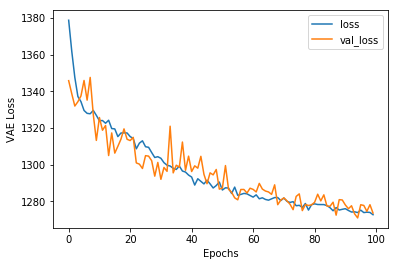

In [18]:
%%time
# Parameters to train nonlinear (VAE) compression method
learning_rate = 0.001
batch_size = 100
epochs = 100
kappa = 0.01
intermediate_dim = 100
latent_dim = 2
epsilon_std = 1.0
num_PCs = latent_dim

base_dir = os.path.dirname(os.getcwd())

# Train nonlinear (VAE)
vae.tybalt_2layer_model(learning_rate, batch_size, epochs, kappa, intermediate_dim,
                        latent_dim, epsilon_std, base_dir, analysis_name)
# Train linear (PCA)
pca.pca_model(base_dir, analysis_name, num_PCs)